# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

## Project: Finding the Indicators for Customer Churn - Sparkify*

## Getting Started

> What is Sparkify ? This is a fictional steaming service like Spotify, Gaana etc. The users can stream the songs that they want, like them if they need and provide a thumbs down if they have to highlight the challenges associated with the songs. Users can actully pay for the Subscription or listen for free.

> What are we going to solve here? As a part of Data sciences team of Sparkify, we were asked to find the indicators for customer churn - What would mean that the Customers would leave Sparkify?

> First, let's wrangle the data and see - 1) Features that we have in the dataset, 2) What are the features that provide a relation with Churn (Exporatory data analysis) 3) Evaluate what model would fit depending on the user characterisitcs

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark import SparkFiles
from pyspark.sql.functions import avg, col, concat, count, desc, \
asc, explode, lit, min, max, split, stddev, udf, isnan, when, rank, \
log, sqrt, cbrt, exp
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, \
LogisticRegressionModel, RandomForestClassifier, \
RandomForestClassificationModel, GBTClassifier, \
GBTClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, \
PCA, RegexTokenizer, Tokenizer, StandardScaler, StopWordsRemover, \
StringIndexer, VectorAssembler, MaxAbsScaler, MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from time import time
import re
import numpy as np
import scipy
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import random
%matplotlib inline
random.seed(42)

In [2]:
# create a Spark session

spark = SparkSession \
    .builder \
    .appName("Capstone Project") \
    .getOrCreate()


# Load and Clean Dataset

In [3]:
df = spark.read.json("mini_sparkify_event_data.json")


In [4]:
#Check for the schema of the data
df.head(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Description of the columns as per my understanding after going through the sample lines-

    1) Artist - Artist name 
    2) Auth - Authentication type
    3) Firstname - First name of the user
    4) Gender - Male/Female
    5) ItemInSession - Item number in session
    6) LastName - Last name of the user
    7) Length - Total track interval
    8) Level - Type of subscription
    9) Location - Geo location of the user
    10) Method - No Idea 
    11) Page - Page in which the user is interaction
    12) Registration - Registration id
    13) Session Id - Unique ID for the session
    14) Song - Song name 
    15) status - No Idea
    16) ts - Time stamp where the user visited
    17) Useragent - Type of the browser/mode of listening used
    18) User ID - Unique ID for the user

In [6]:
# Examine the number of missing values in each column
print(f"Total number of rows in the dataset: {df.count()}.\n")
missing_count_total = 0

for coln in df.columns:
    missing_count = df.filter((isnan(df[coln])) | (df[coln].isNull()) | (df[coln] == "")).count()
    
    if missing_count > 0:
        nan_count = df.filter(isnan(df[coln])).count()
        null_count = df.filter(df[coln].isNull()).count()
        empty_str = df.filter(df[coln] == "").count()
        print(f"{coln}: {missing_count} missing values. \
        {nan_count} NaN's; {null_count} Null's; {empty_str} empty strings.")
        missing_count_total += missing_count
        
if missing_count_total == 0:
    print("No missing values.")

Total number of rows in the dataset: 286500.

artist: 58392 missing values.         0 NaN's; 58392 Null's; 0 empty strings.
firstName: 8346 missing values.         0 NaN's; 8346 Null's; 0 empty strings.
gender: 8346 missing values.         0 NaN's; 8346 Null's; 0 empty strings.
lastName: 8346 missing values.         0 NaN's; 8346 Null's; 0 empty strings.
length: 58392 missing values.         0 NaN's; 58392 Null's; 0 empty strings.
location: 8346 missing values.         0 NaN's; 8346 Null's; 0 empty strings.
registration: 8346 missing values.         0 NaN's; 8346 Null's; 0 empty strings.
song: 58392 missing values.         0 NaN's; 58392 Null's; 0 empty strings.
userAgent: 8346 missing values.         0 NaN's; 8346 Null's; 0 empty strings.
userId: 8346 missing values.         0 NaN's; 0 Null's; 8346 empty strings.


### Summary of changes that we need to do to the dataset -

User ID has some missing values. As we can't track these entries, let's take them out of the dataset


In [7]:
# Drop rows that have empty userId
df = df.dropna(how='any', subset=['userId', 'sessionId'])
df = df.filter(df['userId'] != "")

In [8]:
# page events of null artist values
df.filter(df['artist'].isNull()).select(df['page']).dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [9]:
# page events of NOT null artist values
df.filter(df['artist'].isNotNull()).select(df['page']).dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



From the above two snippets, it is clear that we have the artist information only when the Next song is present

In [10]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

# Exploratory Data Analysis

In [11]:
# Number of unique userId's to be sampled for exploratory data analysis
user_sample_size = 250

# Unique userId's from the full dataset
users = [row.userId for row in df.select('userId').dropDuplicates().collect()]

# Sample userId's
if len(users) > user_sample_size:
    user_sample = list(np.random.choice(users, size=user_sample_size, replace=False))
else:
    user_sample = list(np.copy(users))

# Create subset of the full dataset
df_sub = df.filter(df['userId'].isin(user_sample))

#### Overview of the columns that we have

In [12]:
# Numerical columns (except for sessionId)
num_cols = ['itemInSession', 'registration', 'status', 'ts', 'length']

In [13]:
df_sub.select(num_cols).describe().show()

+-------+------------------+--------------------+------------------+--------------------+-----------------+
|summary|     itemInSession|        registration|            status|                  ts|           length|
+-------+------------------+--------------------+------------------+--------------------+-----------------+
|  count|            278154|              278154|            278154|              278154|           228108|
|   mean|114.89918174824018|1.535358834084427...|209.10321620397335|1.540958915431871...|249.1171819778458|
| stddev|  129.851729399489| 3.291321616327586E9|30.151388851328214|1.5068287123306298E9|99.23517921058361|
|    min|                 0|       1521380675000|               200|       1538352117000|          0.78322|
|    max|              1321|       1543247354000|               404|       1543799476000|       3024.66567|
+-------+------------------+--------------------+------------------+--------------------+-----------------+



In [14]:
coln = 'status'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'status':
[307, 404, 200]


#### Overview of non-numeric columns

In [15]:
# Non-numerical columns (except for userId)
cat_cols = ['auth', 'gender', 'level','method', 
            'page', 'song', 'userAgent', 'location']

In [16]:
for col_name in cat_cols:
    print(f"Unique values of '{col_name}':")
    print([x[col_name] for x in df_sub.select(col_name).dropDuplicates().collect()])

Unique values of 'auth':
['Cancelled', 'Logged In']
Unique values of 'gender':
['F', 'M']
Unique values of 'level':
['free', 'paid']
Unique values of 'method':
['PUT', 'GET']
Unique values of 'page':
['Cancel', 'Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert', 'Logout', 'Save Settings', 'Cancellation Confirmation', 'About', 'Settings', 'Add to Playlist', 'Add Friend', 'NextSong', 'Thumbs Up', 'Help', 'Upgrade', 'Error', 'Submit Upgrade']
Unique values of 'song':
['Never Gonna Be Alone (Album Version)', 'TULENLIEKKI', 'Underwaterboys', 'Saor (Free)/News From Nowhere', 'New E', 'The Geeks Were Right', 'Heaven', 'Call Me Manana', 'Push It', 'Cool Monsoon (Weather Storm)', "The Fun Lovin' Criminal", 'Turn Your Lights Down Low', 'Growing Up', 'Positivity', 'Miracle Man', "I'm The Drug", "I've Just Seen A Face", 'Anna May', 'All The Things She Said', 'Blue Suede Shoes', 'The Beginning', 'Memories of You', 'The Perfect Year', 'Down In Mexico', 'If I Knew Then (What I Know

We have categorical values that needs to be one-hot encoded in order to make them ready for the modelling exercise. The columns on Page, Event, Gender, Status needs to be one-hot encoded

### Define Churn

A column `Churn` is created to use as the label for your model. We used `Cancellation Confirmation` events to define  churn, which happen for both paid and free users

In [17]:
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_sub = df_sub.withColumn("churned", flag_churn_event("page"))

In [18]:
# Calculate percentage of users who churned
pctg = df_sub.groupBy('userId').agg({'churned': 'sum'})\
    .select(avg('sum(churned)')).collect()[0]['avg(sum(churned))']
print(f"{round(pctg*100, 1)}% users have churned.")

23.1% users have churned.


In [19]:
# Calculate flags of churn
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
w = Window.partitionBy('userId')

# 1 means the user has already churned at this timestamp
df_sub = df_sub.withColumn("churnPhase", Fsum('churned').over(windowval))

# 1 means the user is a churn user
df_sub = df_sub.withColumn("churnUser", max('churned').over(w))

In [20]:
df_sub.filter(df_sub['userId']=='125').select('ts','status','churned','page','churnPhase','churnUser').show()

+-------------+------+-------+--------------------+----------+---------+
|           ts|status|churned|                page|churnPhase|churnUser|
+-------------+------+-------+--------------------+----------+---------+
|1539317144000|   200|      0|            NextSong|         0|        1|
|1539317481000|   200|      0|            NextSong|         0|        1|
|1539317711000|   200|      0|            NextSong|         0|        1|
|1539317914000|   200|      0|            NextSong|         0|        1|
|1539318124000|   200|      0|            NextSong|         0|        1|
|1539318515000|   200|      0|            NextSong|         0|        1|
|1539318728000|   200|      0|            NextSong|         0|        1|
|1539318906000|   200|      0|            NextSong|         0|        1|
|1539318917000|   200|      0|         Roll Advert|         0|        1|
|1539318918000|   307|      0|              Cancel|         1|        1|
|1539318918000|   200|      1|Cancellation Conf...|

In [21]:
## Get the relevant date columns

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour, IntegerType())
df_sub = df_sub.withColumn("hour", get_hour(df_sub.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day, IntegerType())
df_sub = df_sub.withColumn("day", get_day(df_sub.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).weekday(), IntegerType())
df_sub = df_sub.withColumn("weekday", get_weekday(df_sub.ts))

In [22]:
df_sub.filter(df_sub['userId']=='125').select('ts','weekday','day','hour','status','churned','page','churnPhase','churnUser').show()

+-------------+-------+---+----+------+-------+--------------------+----------+---------+
|           ts|weekday|day|hour|status|churned|                page|churnPhase|churnUser|
+-------------+-------+---+----+------+-------+--------------------+----------+---------+
|1539317144000|      4| 12|   4|   200|      0|            NextSong|         0|        1|
|1539317481000|      4| 12|   4|   200|      0|            NextSong|         0|        1|
|1539317711000|      4| 12|   4|   200|      0|            NextSong|         0|        1|
|1539317914000|      4| 12|   4|   200|      0|            NextSong|         0|        1|
|1539318124000|      4| 12|   4|   200|      0|            NextSong|         0|        1|
|1539318515000|      4| 12|   4|   200|      0|            NextSong|         0|        1|
|1539318728000|      4| 12|   4|   200|      0|            NextSong|         0|        1|
|1539318906000|      4| 12|   4|   200|      0|            NextSong|         0|        1|
|153931891


### Explore Data
Once we defined churn, we will perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. We will start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Churn rate and Churned users by hour of the day

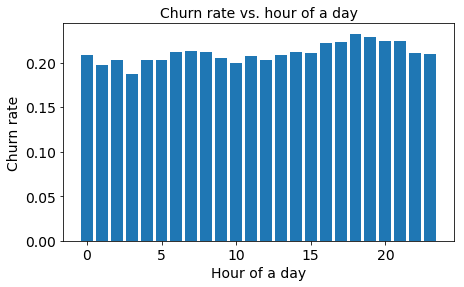

In [23]:
hourly = df_sub.select(['userId', 'hour', 'churnUser'])\
    .dropDuplicates()\
    .groupBy('hour')\
    .agg(count('userId').alias('num_users'), Fsum('churnUser').alias('num_churns'))
hourly_df = hourly.toPandas()

# Visualize hourly patterns
plt.figure(figsize=(7,4))
plt.bar(hourly_df['hour'], hourly_df['num_churns']/hourly_df['num_users'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Hour of a day", fontsize=14)
plt.ylabel("Churn rate", fontsize=14)
plt.title("Churn rate vs. hour of a day", fontsize=14);

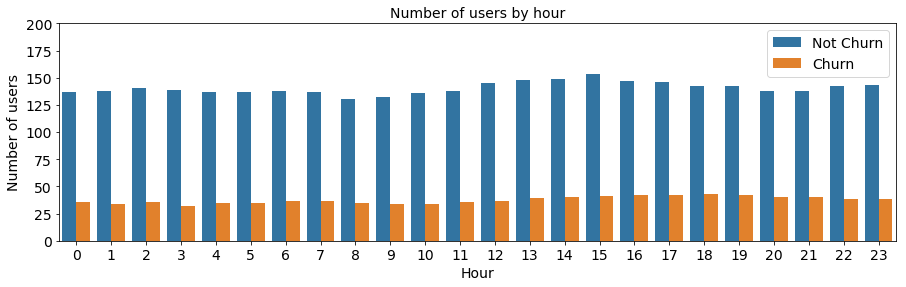

In [24]:
# Visualize the number of users by hour
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
hour_users_pd = df_sub.select(['userId', 'hour', 'churnUser']).dropDuplicates()\
    .withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()

fig = plt.figure(figsize=(15, 4))
sns.countplot(x="hour", hue="churnUser", data=hour_users_pd,
              hue_order=['Not Churn', 'Churn']);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 200)
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Number of users", fontsize=14)
plt.title("Number of users by hour", fontsize=14)
plt.legend(loc='best', fontsize=14);

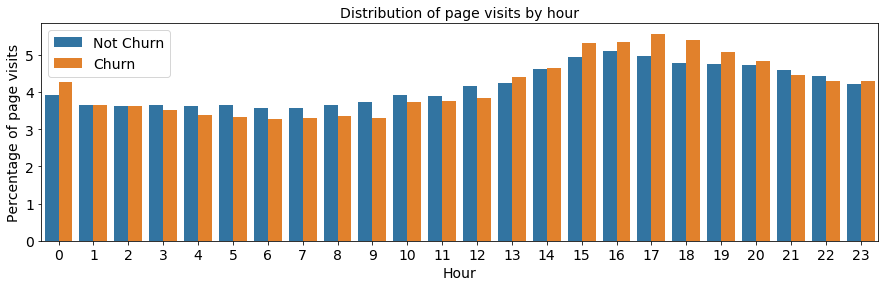

In [25]:
# Visualize the percentage of page events by hour
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

hour_usage_pd = df_sub.withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()
hour_usage_pd = hour_usage_pd.groupby(['churnUser'])['hour']\
    .value_counts(normalize=True).rename('percentage').mul(100).reset_index()

fig = plt.figure(figsize=(15, 4))
sns.barplot(x="hour", y="percentage", hue="churnUser", data=hour_usage_pd,
              hue_order=['Not Churn', 'Churn']);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Percentage of page visits", fontsize=14)
plt.title("Distribution of page visits by hour", fontsize=14)
plt.legend(loc='best', fontsize=14);

#### Churn rate and Churned users by hour of the day

As we can see from the last 3 visualizations, Churn rate is slightly distributed higher in the evening times from 4PM to 11PM. Though this co-incides with the overall non-churn users, definitely activity rate of users is higher during that time. We need to see if we have to treat users differently in this time of the day


#### Churn rate by Day of the week

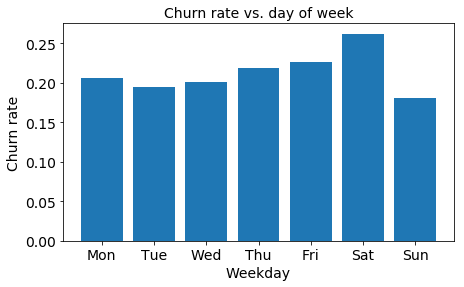

In [26]:
# Calculate day counts
daily = df_sub.select(['userId', 'weekday', 'churnUser'])\
    .dropDuplicates()\
    .groupBy('weekday')\
    .agg(count('userId').alias('num_users'), Fsum('churnUser').alias('num_churns'))
daily_df = daily.toPandas()

# Visualize weekday patterns
plt.figure(figsize=(7,4))
plt.bar(daily_df['weekday'], daily_df['num_churns'] / daily_df['num_users'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Weekday", fontsize=14)
plt.ylabel("Churn rate", fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title("Churn rate vs. day of week", fontsize=14);

#### Churn rate and Churned users by day of the week 

Saturdays is the time when maximum churn and usage happens. However, it needs to be seen if there is a difference in content between weekday and weekends

#### Churn rate by level of the user

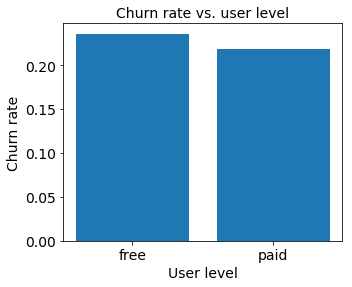

In [27]:
levels = df_sub.select(['userId', 'level', 'churnUser'])\
    .dropDuplicates()\
    .groupBy('level')\
    .agg(count('userId').alias('num_users'), Fsum('churnUser').alias('num_churns'))
levels_df = levels.toPandas()

# Visualize level patterns
plt.figure(figsize=(5,4))
plt.bar(levels_df['level'], levels_df['num_churns'] / levels_df['num_users'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("User level", fontsize=14)
plt.ylabel("Churn rate", fontsize=14)
plt.title("Churn rate vs. user level", fontsize=14);

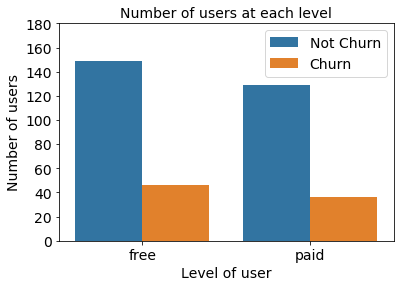

In [28]:

# Visualize the number of users by level
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
level_users_pd = df_sub.select(['userId', 'level', 'churnUser']).dropDuplicates()\
    .withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()

fig = plt.figure(figsize=(6, 4))
sns.countplot(x="level", hue="churnUser", data=level_users_pd,
#                palette=['steelblue', 'orange'], ci=None,
);
plt.ylim(0, 180)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Level of user", fontsize=14)
plt.ylabel("Number of users", fontsize=14)
plt.title("Number of users at each level", fontsize=14)
plt.legend(loc='best', fontsize=14);

#### To summarize the findings from the above, we see a higher rate of Users who churned coming in during the peak hours of the day - same as that of other user. While the Weekend of the day matters as we are seeing higher churn in the weekends. And also the churn rate is more within the Free users than paid users

#### Events variation

In [29]:
# Create pivot table of page events
pages = df_sub.groupBy(['userId']).pivot('page').count().fillna(0)
pages_df = pages.toPandas()

pages_df = pages_df.rename(columns={"Cancellation Confirmation": "Churn"})
pages_df.head()

,userId,About,Add Friend,Add to Playlist,Cancel,Churn,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,3,4,8,0,0,5,0,2,20,5,387,7,0,3,0,1,6,21,2
1,100010,1,4,7,0,0,0,0,2,11,5,275,52,0,0,0,0,5,17,2
2,125,0,0,0,1,1,0,0,0,0,0,8,1,0,0,0,0,0,0,0
3,51,2,28,52,1,1,23,1,12,75,24,2111,0,1,12,0,0,21,100,0
4,124,7,74,118,0,0,41,6,23,176,59,4079,4,6,20,0,0,41,171,0


In [30]:
col_verify = list(pages_df.columns)

col_verify.remove(col_verify[0])

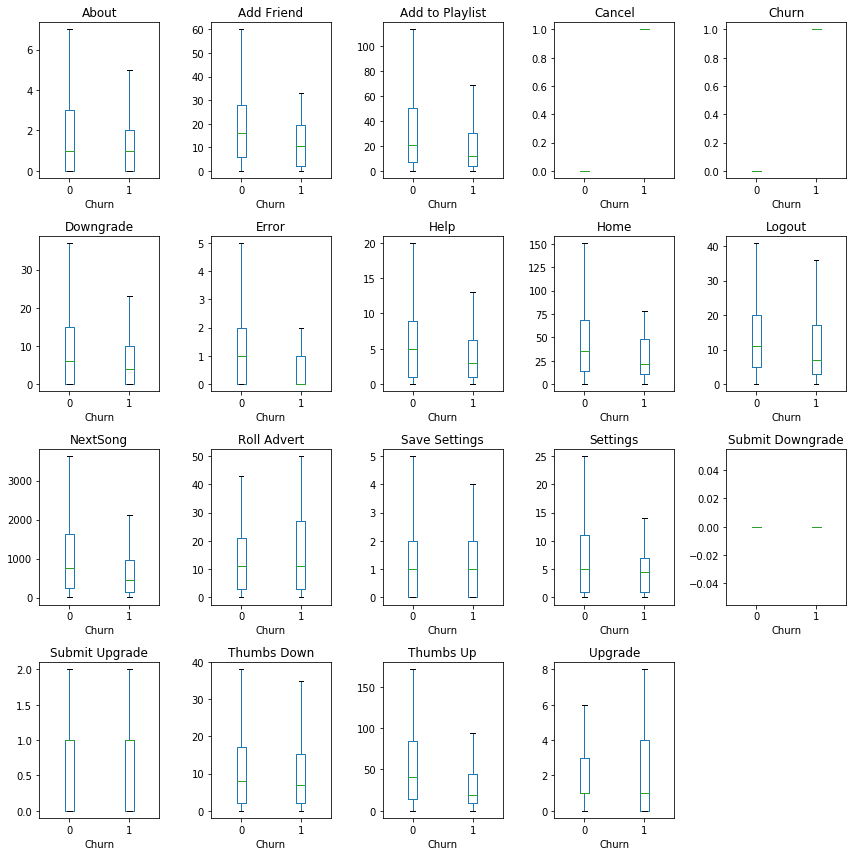

In [31]:
fig = plt.figure(figsize=(12, 12))

for i, coln in enumerate(col_verify):
    ax = fig.add_subplot(4,5,i+1)
    pages_df.boxplot(coln, ax=ax, grid=False,  by='Churn', showfliers=False);

fig.suptitle('')
plt.tight_layout()

    1) Interesting revealation is observed in Roll Advert - Advertisements do annoy the users who churned
    2) Whie the dissatisfaction metrics like THumbs down is same across, the Thumbs up metric is a differentiator between Churned and Non churned users


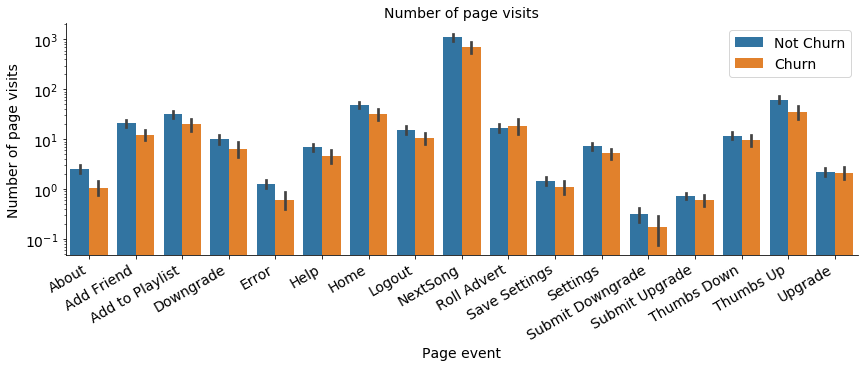

In [32]:
#Visualize the distribution of page events
pages_df['Churn'] = pages_df['Churn'].replace({1: "Churn", 0: "Not Churn"})
pages_df = pages_df.drop('Cancel', axis=1)

page_events_pd = pd.melt(
    pages_df, id_vars=['userId', 'Churn'], 
    value_vars=list(pages_df.columns[1:].drop('Churn')),
    var_name='page', 
    value_name='number_visits'
).reset_index()

fig = plt.figure(figsize=(10, 6))
sns.factorplot(x="page", y="number_visits", hue="Churn", data=page_events_pd,
               kind="bar", aspect=3, legend=False, log=True);
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Page event", fontsize=14)
plt.ylabel("Number of page visits", fontsize=14)
plt.title("Number of page visits", fontsize=14)
plt.legend(loc='best', fontsize=14);

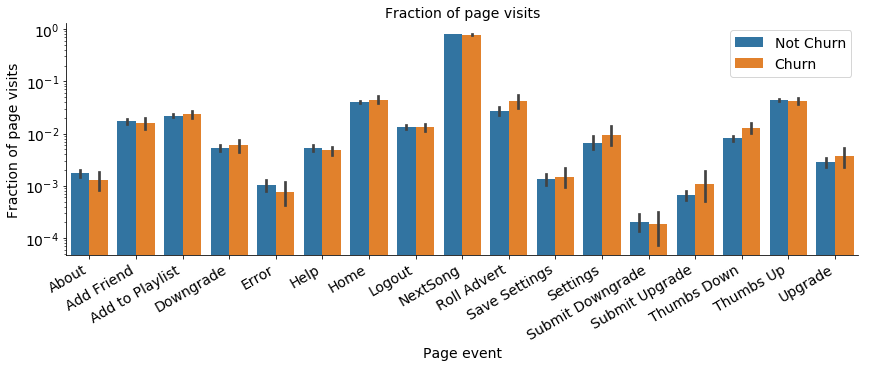

In [33]:
# Visualize the distribution of page events fractions
pages_df['Churn'] = pages_df['Churn'].replace({1: "Churn", 0: "Not Churn"})
# pages_df = pages_df.drop('Cancel', axis=1)

pages_df_frac = pages_df.copy()
event_cols = [coln for coln in pages_df_frac.columns[1:] if coln != 'Churn']
pages_df_frac['total'] = pages_df_frac[event_cols].sum(axis=1)
for coln in event_cols:
    pages_df_frac[coln] = pages_df_frac[coln] / pages_df_frac['total']

page_events_frac_pd = pd.melt(
    pages_df_frac, id_vars=['userId', 'Churn'], 
    value_vars=event_cols,
    var_name='page', 
    value_name='frac_visits'
).reset_index()

fig = plt.figure(figsize=(10, 6))
sns.factorplot(x="page", y="frac_visits", hue="Churn", data=page_events_frac_pd,
               kind="bar", aspect=3, legend=False, log=True);
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Page event", fontsize=14)
plt.ylabel("Fraction of page visits", fontsize=14)
plt.title("Fraction of page visits", fontsize=14)
plt.legend(loc='best', fontsize=14);

#### Churn vs. Device of usage - To do this, we will extract the first string with in the Device section

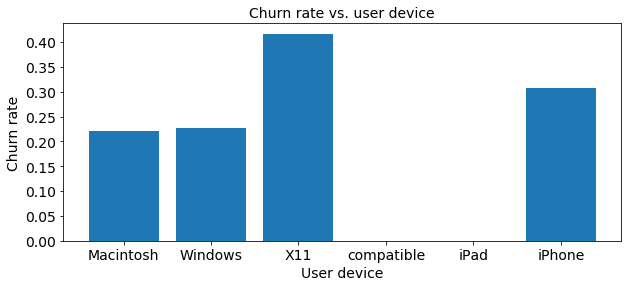

In [34]:
# Calculate churns by device
func_agent_device = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])
df_sub_device = df_sub.withColumn("userAgent", func_agent_device(df_sub["userAgent"]))
df_sub_device.createOrReplaceTempView("df_sub_device_table")

device = df_sub_device.select(['userId', 'userAgent', 'churnUser'])\
    .dropDuplicates()\
    .groupBy('userAgent')\
    .agg(count('userId').alias('num_users'), Fsum('churnUser').alias('num_churns'))
device_df = device.toPandas()

# Visualize device patterns
plt.figure(figsize=(10,4))
plt.bar(device_df['userAgent'], device_df['num_churns'] / device_df['num_users'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("User device", fontsize=14)
plt.ylabel("Churn rate", fontsize=14)
plt.title("Churn rate vs. user device", fontsize=14);

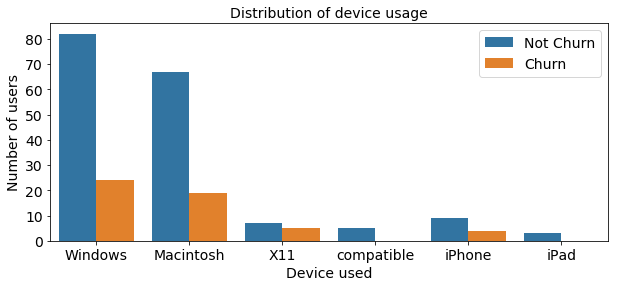

In [35]:
# Calculate churns by device
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
func_agent_device = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])

df_sub_device = df_sub.withColumn("userAgent", func_agent_device(df_sub["userAgent"]))
device_pd = df_sub_device.select(["userId", 'userAgent', 'churnUser'])\
    .dropDuplicates()\
    .withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()

fig = plt.figure(figsize=(10, 4))
sns.countplot(x="userAgent", hue="churnUser", data=device_pd);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Device used", fontsize=14)
plt.ylabel("Number of users", fontsize=14)
plt.title("Distribution of device usage", fontsize=14)
plt.legend(loc='best', fontsize=14);

Though the % users using X11 are experiencing higher logouts the users on this devices are fewer in number

# Feature Engineering

Features to create on per user basis:

 - page-Cancellation Confirmation: Churn (binary)
 - Paid / Free users
 - registration and ts: Time since registration in seconds
 - gender: Gender, "M"->1, "F"->0 (binary)
 - level: Level of user most recently, "paid"->1, "free"->0 (binary)
 - sessionId: Total number of sessions (int)
 - song: Total number of songs the user has listened to (int)
 - artist and song: Statistics of the number of songs per artist that the user has listened to (float)
 - sessionId and ts: Statistics of the time spent per session (float)
 - sessionId and song: Statistics of the number of songs per session (float)
 - userAgent: User agents (binary)
 - page: Number of page events (int)
    Thumbs Up, Thumbs Down, Home, Roll Advert, Logout, Save Settings, About, Settings, Add to Playlist, Add Friend, NextSong, Help, Error, Submit Upgrade, Submit Downgrade

In [36]:
df.createOrReplaceTempView("df_table")

# Define churn
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
churn = df.withColumn("churned", flag_churn_event("page"))\
    .select(['userId', 'churned'])\
    .groupBy('userId').agg(max('churned').alias("churn"))

# Latest level
func_levels = udf(lambda x: 1 if x=="paid" else 0, IntegerType())
levels = df.select(['userId', 'level', 'ts'])\
    .orderBy(desc('ts'))\
    .dropDuplicates(['userId'])\
    .select(['userId', 'level'])\
    .withColumn('level', func_levels('level').cast(IntegerType()))

# Time since registration in seconds, and gender as binary
time_gender = spark.sql(
    '''
    SELECT userId, (MAX(ts) - AVG(registration)) / 1000 time_since_regi,
    AVG(CASE WHEN gender = "M" THEN 1 ELSE 0 END) gender
    FROM df_table
    GROUP BY userId
    '''
)

# Statistics of the time spent sper session (float)
per_session = spark.sql(
    '''
    SELECT userId, stddev_samp(time) std_time_per_session
    FROM
        (SELECT userId, sessionId, (MAX(ts) - MIN(ts))/1000 AS time, COUNT(song) num_songs
        FROM df_table
        GROUP BY userId, sessionId) per_session
    GROUP BY userId
    '''
).fillna(0)

In [37]:
window = Window.partitionBy("userId").rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
func_agent_device = udf(lambda x: "user_agent_"+x.split('(')[1].replace(";", " ").split(" ")[0])

agents = df.withColumn("userAgent", func_agent_device(df["userAgent"]))\
    .select(["userId", 'userAgent'])\
    .groupBy(["userId", 'userAgent'])\
    .agg(count("userAgent").alias("user_agent_usage"))\
    .withColumn('total', Fsum(col('user_agent_usage')).over(window))\
    .withColumn('user_agent_usage', col('user_agent_usage')/col('total'))\
    .groupBy("userId").pivot("userAgent").sum("user_agent_usage").fillna(0)

# Count usages of each page event by each user
pages_to_exclude = ['Cancel', 'Downgrade', 'Cancellation Confirmation', 'Upgrade']
func_pages = udf(lambda x: "page_"+x.replace(" ", "_").lower())
pages = df.filter(~df['page'].isin(pages_to_exclude))\
    .withColumn("page", func_pages(df["page"]))\
    .groupBy(['userId']).pivot("page").agg(count('page'))\
    .fillna(0)
pages = pages.withColumn("page_up_down_ratio", pages["page_thumbs_up"]/(pages['page_thumbs_down']+0.1))

# Calculate the fraction of each page event by each user
pages = pages.withColumn(
    'total', sum(pages[coln] for coln in pages.columns if coln not in ['userId', 'page_up_down_ratio'])
)
for coln in pages.columns:
    if coln not in ['userId', 'total', 'page_up_down_ratio']:
        new_col_name = coln[0:5]+'frac_'+coln[5:]
        pages = pages.withColumn(new_col_name, pages[coln] / pages['total'])
pages = pages.drop('total')


In [38]:
#Merge all the datasets

# Join features together
dataset = churn.join(levels, ['userId'])\
    .join(time_gender, ['userId'])\
    .join(per_session, ['userId'])\
    .join(agents, ['userId'])\
    .join(pages, ['userId'])


dataset.head(2)

[Row(userId='100010', churn=0, level=0, time_since_regi=4807612.0, gender=0.0, std_time_per_session=5719.952913559108, user_agent_Macintosh=0.0, user_agent_Windows=0.0, user_agent_X11=0.0, user_agent_compatible=0.0, user_agent_iPad=0.0, user_agent_iPhone=1.0, page_about=1, page_add_friend=4, page_add_to_playlist=7, page_error=0, page_help=2, page_home=11, page_logout=5, page_nextsong=275, page_roll_advert=52, page_save_settings=0, page_settings=0, page_submit_downgrade=0, page_submit_upgrade=0, page_thumbs_down=5, page_thumbs_up=17, page_up_down_ratio=3.3333333333333335, page_frac_about=0.002638522427440633, page_frac_add_friend=0.010554089709762533, page_frac_add_to_playlist=0.018469656992084433, page_frac_error=0.0, page_frac_help=0.005277044854881266, page_frac_home=0.029023746701846966, page_frac_logout=0.013192612137203167, page_frac_nextsong=0.7255936675461742, page_frac_roll_advert=0.13720316622691292, page_frac_save_settings=0.0, page_frac_settings=0.0, page_frac_submit_downgra

# Pre Modeling operations
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [39]:
# Convert to pandas
dataset_pd = dataset.toPandas()

In [40]:
dataset_pd.head()

,userId,churn,level,time_since_regi,gender,std_time_per_session,user_agent_Macintosh,user_agent_Windows,user_agent_X11,user_agent_compatible,...,page_frac_home,page_frac_logout,page_frac_nextsong,page_frac_roll_advert,page_frac_save_settings,page_frac_settings,page_frac_submit_downgrade,page_frac_submit_upgrade,page_frac_thumbs_down,page_frac_thumbs_up
0,100010,0,0,4807612.0,0.0,5719.952914,0.0,0.0,0.0,0.0,...,0.029024,0.013193,0.725594,0.137203,0.000000,0.000000,0.0,0.000000,0.013193,0.044855
1,200002,0,1,6054448.0,1.0,13016.721707,0.0,0.0,0.0,0.0,...,0.042827,0.010707,0.828694,0.014989,0.000000,0.006424,0.0,0.002141,0.012848,0.044968
2,125,1,0,6161779.0,1.0,0.000000,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.888889,0.111111,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,124,0,1,11366431.0,0.0,33771.341222,1.0,0.0,0.0,0.0,...,0.036789,0.012333,0.852634,0.000836,0.001254,0.004181,0.0,0.000000,0.008570,0.035744
4,51,1,1,1680985.0,1.0,42019.173209,0.0,1.0,0.0,0.0,...,0.030750,0.009840,0.865519,0.000000,0.000410,0.004920,0.0,0.000000,0.008610,0.041000


In [41]:
dataset_pd.churn.sum()

52

In [42]:
# Find correlated features that have absolute correlation >= 0.5
corr_matrix = dataset_pd.corr()
correlated_cols = []
for coln in corr_matrix.columns:
    correlated = corr_matrix.drop(coln, axis=0).loc[corr_matrix[coln].abs()>=0.5].index.tolist()
    if len(correlated) > 0:
        correlated_cols.append(coln)

In [43]:
corr = dataset_pd[correlated_cols].corr()
cols_to_remove = []
counter = 0
for coln in corr.columns:
    counter += 1
    if corr[coln].iloc[counter:].max() >= 0.8:
        cols_to_remove.append(coln)
print(f"Highly correlated features that should be removed:\n\n{cols_to_remove}\n\n")
cols_to_keep = dataset_pd.columns.drop(cols_to_remove).tolist()
print(f"Features to keep:\n\n{cols_to_keep}")

Highly correlated features that should be removed:

['page_add_friend', 'page_add_to_playlist', 'page_help', 'page_home', 'page_logout', 'page_nextsong', 'page_settings']


Features to keep:

['userId', 'churn', 'level', 'time_since_regi', 'gender', 'std_time_per_session', 'user_agent_Macintosh', 'user_agent_Windows', 'user_agent_X11', 'user_agent_compatible', 'user_agent_iPad', 'user_agent_iPhone', 'page_about', 'page_error', 'page_roll_advert', 'page_save_settings', 'page_submit_downgrade', 'page_submit_upgrade', 'page_thumbs_down', 'page_thumbs_up', 'page_up_down_ratio', 'page_frac_about', 'page_frac_add_friend', 'page_frac_add_to_playlist', 'page_frac_error', 'page_frac_help', 'page_frac_home', 'page_frac_logout', 'page_frac_nextsong', 'page_frac_roll_advert', 'page_frac_save_settings', 'page_frac_settings', 'page_frac_submit_downgrade', 'page_frac_submit_upgrade', 'page_frac_thumbs_down', 'page_frac_thumbs_up']


Correlations among the remaining features:


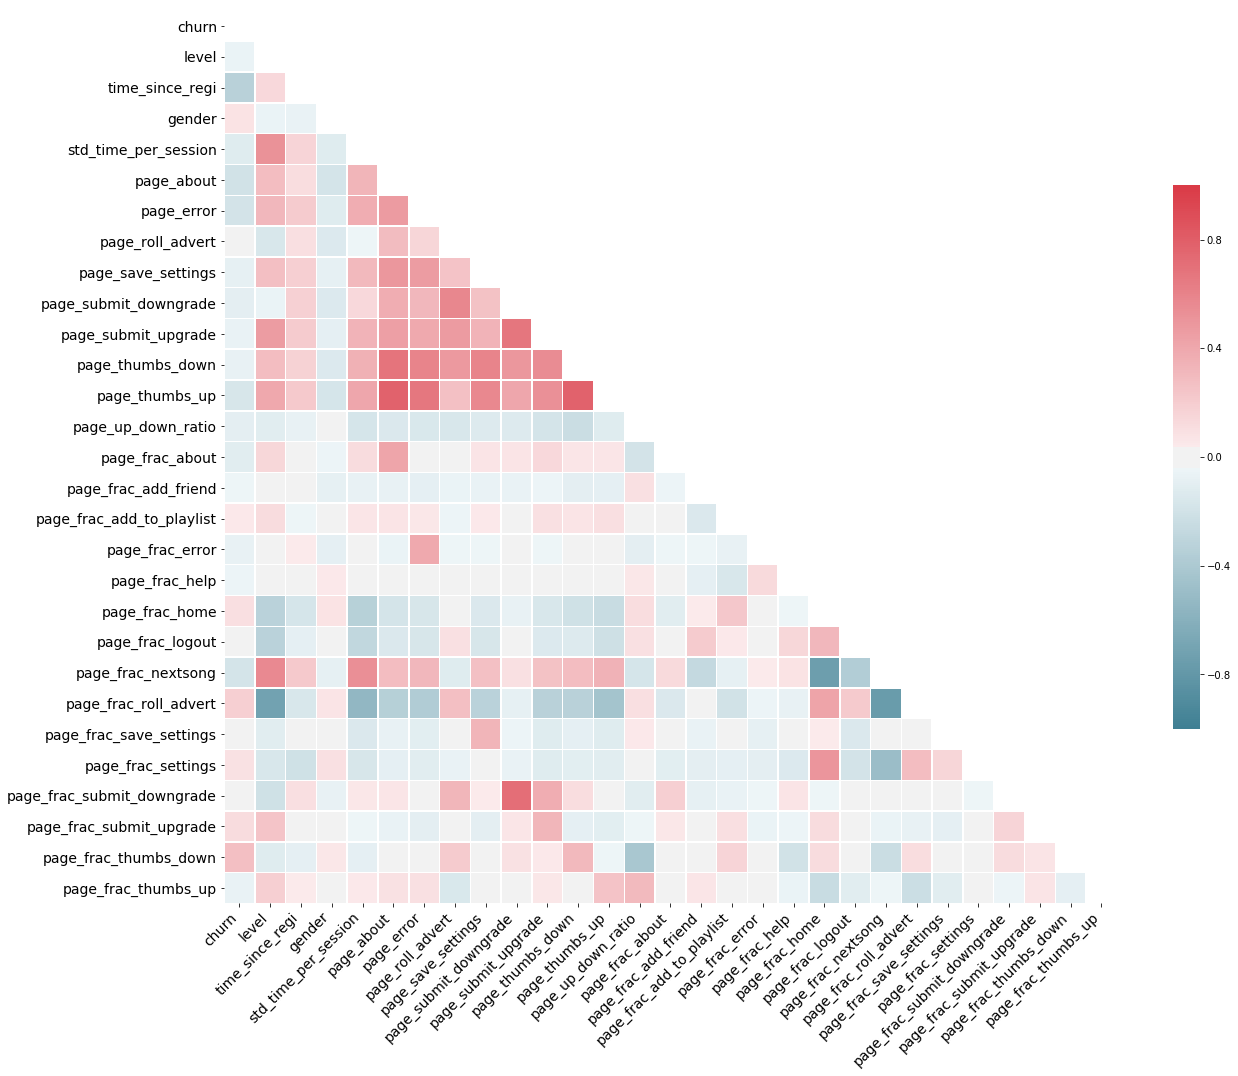

In [45]:
# Visualize correlations of the remaining features
print("Correlations among the remaining features:")
cols_to_keep_corr = [coln for coln in cols_to_keep if ('user_agent' not in coln) & ('userId' not in coln)]
corr_remaining = dataset_pd[cols_to_keep_corr].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_remaining, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(
    corr_remaining, mask=mask, cmap=cmap, center=0,
    vmin=-1, vmax=1, 
    square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
    xticklabels=cols_to_keep_corr,
    yticklabels=cols_to_keep_corr,
#     annot=True
)
plt.xticks(rotation=45, ha='right', fontsize=14) 
plt.yticks(fontsize=14);
# ax.figure.axes[-1].yaxis.label.set_size(14)

#### Feature transformation

Examine feature distributions:


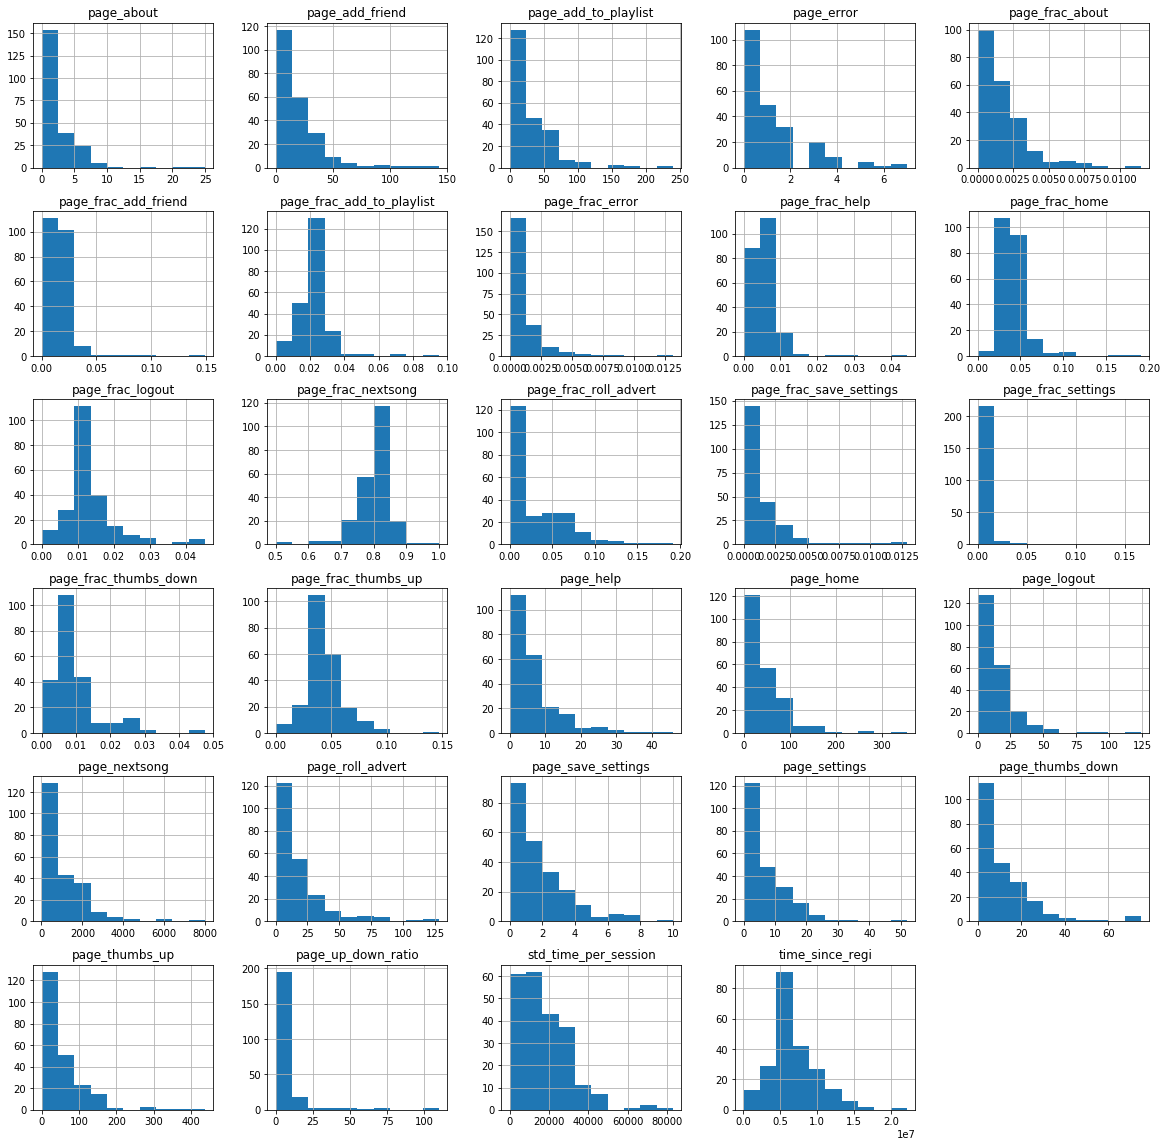

In [46]:
print("Examine feature distributions:")
col_names = [coln for coln in dataset_pd.columns if 
             ('churn' not in coln) and 
             ('level' not in coln) and
             ('userId' not in coln) and
             ('gender' not in coln) and
             ('user_agent_' not in coln) and
             ('location_' not in coln) and
             ('_submit_' not in coln)
            ]
dataset_pd[col_names].hist(figsize=(20,20));

We can see a skew in almost all the metrics. Let's transfrom the columns using 'Sqrt' and 'Log' transformation

Examine feature distributions:


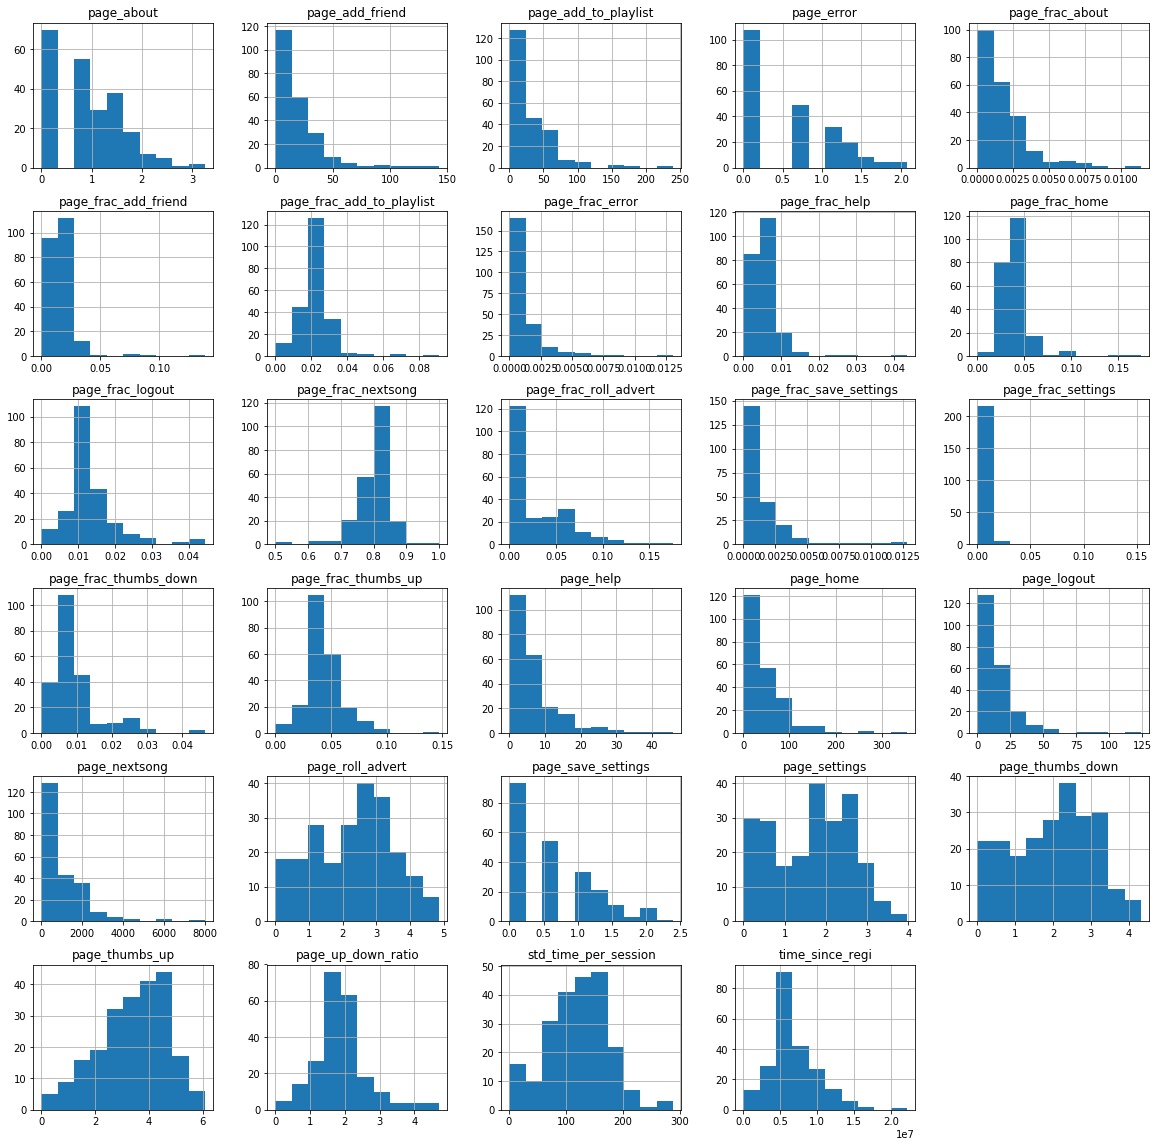

In [47]:
to_sqrt = ['std_time_per_session']
to_log = [
    'page_about', 'page_error', 'page_roll_advert', 'page_save_settings', 
    'page_thumbs_down', 'page_frac_about', 'page_frac_add_friend', 
    'page_frac_add_to_playlist', 'page_frac_error', 'page_frac_help', 
    'page_frac_home', 'page_frac_logout', 'page_frac_roll_advert', 
    'page_frac_save_settings', 'page_frac_settings', 
    'page_frac_submit_downgrade', 'page_frac_submit_upgrade', 
    'page_frac_thumbs_down', 'page_settings', 'page_thumbs_up',
    'page_up_down_ratio'
]

for col_name in col_names:
    if col_name in to_sqrt:
        dataset = dataset.withColumn(col_name, sqrt(dataset[col_name]+1))
    elif col_name in to_log:
        dataset = dataset.withColumn(col_name, log(dataset[col_name]+1))

print("Examine feature distributions:")
dataset_pd = dataset.toPandas()
dataset_pd[col_names].hist(figsize=(20,20));

In [48]:
# Drop the highly correlated features
cols_to_keep = [
    'userId', 'churn', 'level', 'time_since_regi', 'gender', 'std_time_per_session', 
    'user_agent_Macintosh', 'user_agent_Windows', 'user_agent_X11', 
    'user_agent_compatible', 'user_agent_iPad', 'user_agent_iPhone', 'page_about', 
    'page_error', 'page_roll_advert', 'page_save_settings', 'page_submit_downgrade', 
    'page_submit_upgrade', 'page_thumbs_down', 'page_thumbs_up', 'page_frac_about', 
    'page_frac_add_friend', 'page_frac_add_to_playlist', 'page_frac_error', 
    'page_frac_help', 'page_frac_home', 'page_frac_logout', 'page_frac_nextsong', 
    'page_frac_roll_advert', 'page_frac_save_settings', 'page_frac_settings', 
    'page_frac_submit_downgrade', 'page_frac_submit_upgrade', 'page_frac_thumbs_down', 
    'page_frac_thumbs_up',  'page_up_down_ratio'
]
dataset = dataset.select(cols_to_keep)

# Feature transformation
to_sqrt = ['std_time_per_session']
to_log = [
    'page_about', 'page_error', 'page_roll_advert', 'page_save_settings', 
    'page_thumbs_down', 'page_frac_about', 'page_frac_add_friend', 
    'page_frac_add_to_playlist', 'page_frac_error', 'page_frac_help', 
    'page_frac_home', 'page_frac_logout', 'page_frac_roll_advert', 
    'page_frac_save_settings', 'page_frac_settings', 
    'page_frac_submit_downgrade', 'page_frac_submit_upgrade', 
    'page_frac_thumbs_down', 'page_settings', 'page_thumbs_up',
    'page_up_down_ratio'
]
col_names = [
    coln for coln in dataset.columns if 
    ('churn' not in coln) and 
    ('level' not in coln) and
    ('userId' not in coln) and
    ('gender' not in coln) and
    ('user_agent_' not in coln) and
    ('_submit_' not in coln)
]
for col_name in col_names:
    if col_name in to_sqrt:
        dataset = dataset.withColumn(col_name, sqrt(dataset[col_name]+1))
    elif col_name in to_log:
        dataset = dataset.withColumn(col_name, log(dataset[col_name]+1))

## Modeling

In [49]:
# Confirm missing values
dataset_pd = dataset.toPandas()
missing_value_count = dataset_pd.isnull().sum().sum()
print(f"{missing_value_count} missing value left.")

0 missing value left.


In [50]:
# Rename churn column into label
dataset = dataset.withColumn('label', dataset['churn'].cast('float')).drop('churn') #important to have float type

# Feature columns to be converted into vector
feature_cols = dataset.drop('label').drop('userId').columns

# Train-test split
train, test = dataset.drop('userId').randomSplit([0.8, 0.2], seed=42)


### Evaluation Metrics - F Score, Accuracy

### Metrics and the Naive Predictor

It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. However, a model's ability to precisely predict those that are more likely is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

In [51]:
def buildCV(classifier, paramGrid):
    '''
    Build a cross validation pipeline
    
    INPUT
    classifier: untrained machine learning classifier
    paramGrid: a grid of parameters to search over
    
    OUTPUT
    crossval: cross validator
    '''
    # Configure an ML pipeline
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="rawFeatures")
    scaler = MaxAbsScaler(inputCol="rawFeatures", outputCol="scaledFeatures")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    # Cross validation
    crossval = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=MulticlassClassificationEvaluator(metricName='f1'),
        numFolds=3
    )
    return crossval

In [52]:
def trainModel(classifier, train, paramGrid):
    '''
    Train the machine learning model
    
    INPUT
    classifier: untrained machine learning classifier
    paramGrid: a grid of parameters to search over
    train (Spark dataframe): training dataset
    
    OUTPUT
    model: trained machine learning model
    training_time (float): training time
    '''
    crossval = buildCV(classifier, paramGrid)
    start = time()
    model = crossval.fit(train)
    end = time()
    training_time = end - start
    return model, training_time

In [53]:
def evaluateModel(model, data, prob=False):
    '''
    Evaluate model performance
    
    INPUT
    model: trained machine learning model
    data (Spark dataframe): either training set or testing set
    
    OUTPUT
    evalMetrics (dict): disctionary of evaluation metrics
    '''
    # Make prediction
    start = time()
    pred = model.transform(data)
    if prob:
        evaluator = MulticlassClassificationEvaluator(predictionCol="probability", labelCol="label")
    else:
        evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    end = time()
    prediction_time = end - start
    
    # Calculate metrics
    evalMetrics = {}
    evalMetrics["precision"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
    evalMetrics["recall"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
    evalMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    evalMetrics["accuracy"] = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
    evalMetrics['confusion_matrix'] = pred.groupby("label").pivot("prediction").count()
    evalMetrics['prediction_time'] = prediction_time
    
    return evalMetrics

def evaluateTrainTest(model, train, test, training_time):
    '''
    Evaluate model performance on both training and testing sets
    
    INPUT
    model: trained machine learning model
    train: training set
    test: testing set
    training_time (float): training time
    
    OUTPUT
    evalMetrics (dict): disctionary of evaluation metrics, 
        compiled from training, testing metrics
    summary (Spark dataframe): table of evaluation metrics
    '''
    # Evaluate model performance
    evalMetricsTraining = evaluateModel(model, train)
    evalMetricsTesting = evaluateModel(model, test)

    # Compile metrics
    evalMetrics = {}
    evalMetrics['train_time'] = training_time
    evalMetrics['f1_train'] = evalMetricsTraining['f1']
    evalMetrics['acc_train'] = evalMetricsTraining['accuracy']
    evalMetrics['f1_test'] = evalMetricsTesting['f1']
    evalMetrics['acc_test'] = evalMetricsTesting['accuracy']
    evalMetrics['pred_time'] = evalMetricsTraining['prediction_time'] \
        + evalMetricsTesting['prediction_time']

    # Summarize metrics into a Spark dataframe
    metrics_to_display = {
        k:round(v, 4) for k,v in evalMetrics.items() if ('confusion_matrix' not in k)
    }
    summary = spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys()))
    
    return evalMetrics, summary

In [54]:
# Lump all steps together
def trainAndEval(classifier, train, test, paramGrid):
    '''
    Train and evaluate model performance on both training and testing sets
    
    INPUT
    classifier: untrained machine learning classifier
    train: training set
    test: testing set
    paramGrid: a grid of parameters to search over
    
    OUTPUT
    evalMetrics (dict): disctionary of evaluation metrics, 
        compiled from training, testing metrics
    summary (Spark dataframe): table of evaluation metrics
    model: trained machine learning model
    '''
    # Train the model
    model, training_time = trainModel(classifier, train, paramGrid)
    
    # Evaluate model performance
    evalMetricsTraining = evaluateModel(model, train)
    evalMetricsTesting = evaluateModel(model, test)

    # Compile metrics
    evalMetrics = {}
    evalMetrics['train_time'] = training_time
    evalMetrics['f1_train'] = evalMetricsTraining['f1']
    evalMetrics['acc_train'] = evalMetricsTraining['accuracy']
    evalMetrics['f1_test'] = evalMetricsTesting['f1']
    evalMetrics['acc_test'] = evalMetricsTesting['accuracy']
    evalMetrics['pred_time'] = evalMetricsTraining['prediction_time'] \
        + evalMetricsTesting['prediction_time']

    # Summarize metrics into a Spark dataframe
    metrics_to_display = {
        k:round(v, 4) for k,v in evalMetrics.items() if ('confusion_matrix' not in k)
    }
    summary = spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys()))
    
    return evalMetrics, summary, model

In [55]:
## Evaluation

# Make prediction
pred = dataset.select("label").withColumn("prediction", lit(0.0))

# Calculate metrics
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
evalMetrics = {}
evalMetrics["precision"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
evalMetrics["recall"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
evalMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
evalMetrics["accuracy"] = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
evalMetrics['confusion_matrix'] = pred.groupby("label").pivot("prediction").count()

# Show metrics
print('Naive model:')
metrics_to_display = {k:round(v, 4) for k,v in evalMetrics.items() if k != 'confusion_matrix'}
spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys())).show()

Naive model:
+---------+------+------+--------+
|precision|recall|    f1|accuracy|
+---------+------+------+--------+
|   0.5912|0.7689|0.6684|  0.7689|
+---------+------+------+--------+



#### Model - 2 : Logistic regression

In [56]:
classifier = LogisticRegression(labelCol="label", featuresCol="scaledFeatures")
paramGrid=ParamGridBuilder().build()

In [57]:
evalMetrics, summary, model = trainAndEval(classifier, train, test, paramGrid)

In [58]:
# Show metrics
print("Logistic Regression:")
summary.show()

Logistic Regression:
+----------+--------+---------+-------+--------+---------+
|train_time|f1_train|acc_train|f1_test|acc_test|pred_time|
+----------+--------+---------+-------+--------+---------+
| 1586.0231|  0.8399|   0.8534| 0.7037|  0.7353|   0.4959|
+----------+--------+---------+-------+--------+---------+



#### Model - 3 : Random Forest

In [59]:
## Random Forest

# Train the model and evaluate performance
classifier = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures")
paramGrid=ParamGridBuilder().build()
evalMetrics, summary, model = trainAndEval(classifier, train, test, paramGrid)

# Save the best model
bestModel = model.bestModel
bestCLModel = bestModel.stages[2]
bestCLModel.save("random_forest")

# Show metrics
print("Random Forest:")
summary.show()

Random Forest:
+----------+--------+---------+-------+--------+---------+
|train_time|f1_train|acc_train|f1_test|acc_test|pred_time|
+----------+--------+---------+-------+--------+---------+
|  745.1116|  0.9513|   0.9529| 0.8083|  0.8235|   0.4198|
+----------+--------+---------+-------+--------+---------+



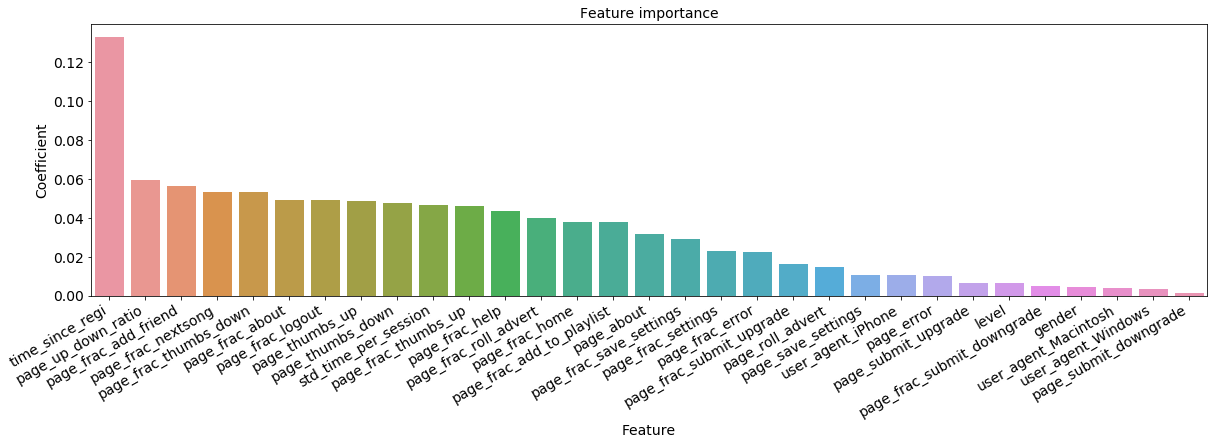

In [60]:

bestCLModel = RandomForestClassificationModel.load("random_forest")

# Feature importance
feature_ind = bestCLModel.featureImportances.indices.tolist()
feature_name = [feature_cols[ind] for ind in feature_ind]
feature_coef = bestCLModel.featureImportances.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(feature_name, feature_coef)), columns=['Feature', 'Coefficient'])\
    .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Coefficient', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14);

### Conclusion on the model to use

    1. From the above 3 models that we built - A Naive baives base classifier is able to give us an accuracy of 76% and recall of 66% 
    2. While the Logistic regression definitely has an improvement, it is time consuming method when compared to the Random forest - Operationaly faster and easy to evaluate

> Ideally, we would go for Hyperparameter tuning of Random forest algorithm. Since our objective is to find out the relevant features that are responsible for churn - a directional understanding of the features would be adequate

## Drivers of Churn

>Sparkify team needs to focus on customer retention through a detailed plan on improvements with in customer engagement.Especially during the peak hour times and weekend. The good news is Customers love our interface. All we need to see is how to make them engaged
    1. Time since the registration is a sure indicator of churn - Which would mean : Over time the Sparkify app is not able to capitalize on the existing base
    2. Page - Up - Down ratio - Content needs to be curated and looked into if we have to understand why the users are giving Page Thumbs up & down respectively
    3. The user interface that we have is adequate at the moment. They are not indicating the churn influencers
    
Having said that, we also need to understand the competitor apps / rival apps engagement and initiatives that is going there. If we can get intelligence around that, we can triage and form an informed decision on arresting the churn with in Sparkify customer base